In [1]:
# Packages and libraries required

# Display pretty table for dataframe
from IPython.display import display

import numpy as np
import pandas as pd

from datetime import datetime, date
from math import sqrt, ceil

from pandas.plotting import table

from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib import dates as mdates

# For dividend and risk free rate
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS

# Directory browsing and local file storage access
import glob
import os

import scipy.stats as ss

# Quantitative Finance - Option Valuation library
import QuantLib as ql

In [2]:
# Functions used in the notebook

# Get 3 months T-bill rate from FRED
def get_risk_free_rate():
    # Get 3month T-bill rate from FRED for Risk Free Rate
    try:
        tb3ms = web.DataReader('TB3MS', 'fred')
        risk_free_rate = tb3ms.iloc[-1].values[0] / 100.0
    except:
        # set to 1% if can't retrieve
        risk_free_rate = 0.01

    return risk_free_rate

# Get Dividend history for a security
def get_dividend(security):
    # Get dividend from Yahoo
    try:
        dividends = web.DataReader(security, 'yahoo-dividends')
        # latest dividend value
        dividend = dividends.iloc[0]['value']
    except:
        # set to no dividend if can't retrieve
        dividend = 0.0
        
    return dividend

# Calculate option value and greeks using  Black-Scholes-Morten Model
def calc_bsm_stats(df, dividend=0.0, risk_free_rate=0.01):
    # Input
    #. A dataframe of option data with single row
    #.. df.Expiry
    #.. df.Underlying_Price
    #.. df.Strike
    #.. df.IV
    #.. df.Bid, df.Ask for implied volatility calc
    #.. df.Type
    #
    # Output
    #. Return dataframe with added columns for BSM stats
    #.. bs_price
    #.. bs_delta
    #.. bs_gamma
    #.. bs_vega
    #.. bs_theta
    #.. bs_rho
    #.. bs_elasticity
    #.. bs_iv
        
    # option data
    d = datetime.strptime(df.Expiry,'%Y-%m-%d')
    maturity_date = ql.Date(d.day, d.month, d.year)

    spot_price = df.Underlying_Price
    strike_price = df.Strike
    volatility = df.IV
    
    dividend_rate = dividend / spot_price

    if (df.Type == 'call'):
        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put
    
    # Option evaluation date
    calculate_date = ql.Date_todaysDate()
    
    # Collect quoted market data
    u = ql.SimpleQuote(spot_price)
    r = ql.SimpleQuote(risk_free_rate)
    sigma = ql.SimpleQuote(volatility)

    # Get Black-Scholes-Merton model
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()

    ql.Settings.instance().evaluationDate = calculate_date

    # Construct the European Option
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)

    # Black-Scholes-Merton
    riskFreeCurve = ql.FlatForward(0, calendar, ql.QuoteHandle(r), day_count)
    volatility = ql.BlackConstantVol(0, calendar, ql.QuoteHandle(sigma), day_count)
    dividendCurve = ql.FlatForward(0, calendar, dividend_rate, day_count, ql.Quarterly)

    flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
    dividend_yield = ql.YieldTermStructureHandle(dividendCurve)
    flat_vol_ts = ql.BlackVolTermStructureHandle(volatility)

    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(u), 
                                               dividend_yield, 
                                               flat_ts, 
                                               flat_vol_ts)

    engine = ql.AnalyticEuropeanEngine(bsm_process)
    european_option.setPricingEngine(engine)
    
    # Compute theoretical price and greeks
    df['bs_price'] = european_option.NPV()
    df['bs_delta'] = european_option.delta()
    df['bs_gamma'] = european_option.gamma()
    df['bs_vega'] = european_option.vega()
    df['bs_theta'] = european_option.thetaPerDay()
    df['bs_rho'] = european_option.rho()
    df['bs_elasticity'] = european_option.elasticity()
    
    # Calculate Implied Volatility if Option Bid and Ask are available
    try:
        option_bid_ask_mid = (df.Bid + df.Ask) / 2.0
        df['bs_iv'] = european_option.impliedVolatility(option_bid_ask_mid, bsm_process)
    except:
        df['bs_iv'] = None

    return df

# Calculate Option Stats as Underlying Price change
def get_option_stats_with_price(df, underlying_range, dividend=0.0, risk_free_rate=0.01):

    # For a single option, calculate option values and greeks as underlying price changes, 
    # using Black-Scholes_Merton Model

    # Get the BSM option model

    # option data
    d = datetime.strptime(df.Expiry.values[0],'%Y-%m-%d')
    maturity_date = ql.Date(d.day, d.month, d.year)

    spot_price = df.Underlying_Price.values[0]
    strike_price = df.Strike.values[0]
    imp_vol = df.IV.values[0]
    dividend_rate = dividend / spot_price

    if (df.Type == 'call').bool():

        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put

    # Option evaluation date
    calculate_date = ql.Date_todaysDate()

    # Collect quoted market data
    u = ql.SimpleQuote(spot_price)
    r = ql.SimpleQuote(risk_free_rate)
    sigma = ql.SimpleQuote(imp_vol)

    # Get Black-Scholes-Morten Model
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()

    ql.Settings.instance().evaluationDate = calculate_date

    # Construct the European Option
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)

    # Black-Scholes-Merton
    riskFreeCurve = ql.FlatForward(calculate_date, ql.QuoteHandle(r), day_count)
    volatility = ql.BlackConstantVol(calculate_date, calendar, ql.QuoteHandle(sigma), day_count)
    dividendCurve = ql.FlatForward(calculate_date, dividend_rate, day_count, ql.Quarterly)

    flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
    dividend_yield = ql.YieldTermStructureHandle(dividendCurve)
    flat_vol_ts = ql.BlackVolTermStructureHandle(volatility)

    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(u), 
                                               dividend_yield, 
                                               flat_ts, 
                                               flat_vol_ts)

    engine = ql.AnalyticEuropeanEngine(bsm_process)
    european_option.setPricingEngine(engine)

    result_df = pd.DataFrame()
    
    for spot_price in underlying_range:
        u.setValue(spot_price)
        # add to result_df
        result_df = pd.concat([result_df, 
                               pd.DataFrame({'Strike': strike_price,
                                  'Expiry': df.Expiry,
                                  'Type': df.Type,
                                  'Symbol': df.Symbol, 
                                  'stock_price': spot_price,
                                  'imp_vol': imp_vol,
                                  'dte': df.dte,
                                  'bs_price': european_option.NPV(),
                                  'bs_delta': european_option.delta(),
                                  'bs_gamma': european_option.gamma(),
                                  'bs_vega': european_option.vega(),
                                  'bs_theta': european_option.thetaPerDay(),
                                  'bs_rho': european_option.rho(),
                                  'bs_elasticity': european_option.elasticity()
                                 })
                              ], ignore_index=True)

    # Reset Spot Price to current stock price
    u.setValue(df.Underlying_Price.values[0])
    
    return result_df

# Calculate Option Stats as Implied Volatility Changes
def get_option_stats_with_volatility(df, volatility_range, dividend=0.0, risk_free_rate=0.01):

    # For a single option, calculate option values and greeks as volatility changes, 
    # using Black-Scholes_Merton Model

    # Get the BSM option model

    # option data
    d = datetime.strptime(df.Expiry.values[0],'%Y-%m-%d')
    maturity_date = ql.Date(d.day, d.month, d.year)

    spot_price = df.Underlying_Price.values[0]
    strike_price = df.Strike.values[0]
    imp_vol = df.IV.values[0]
    dividend_rate = dividend / spot_price

    if (df.Type == 'call').bool():

        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put

    # Option evaluation date
    calculate_date = ql.Date_todaysDate()

    # Collect quoted market data
    u = ql.SimpleQuote(spot_price)
    r = ql.SimpleQuote(risk_free_rate)
    sigma = ql.SimpleQuote(imp_vol)

    # Get Black-Scholes-Morten Model
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()

    ql.Settings.instance().evaluationDate = calculate_date

    # Construct the European Option
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)

    # Black-Scholes-Merton
    riskFreeCurve = ql.FlatForward(calculate_date, ql.QuoteHandle(r), day_count)
    volatility = ql.BlackConstantVol(calculate_date, calendar, ql.QuoteHandle(sigma), day_count)
    dividendCurve = ql.FlatForward(calculate_date, dividend_rate, day_count, ql.Quarterly)

    flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
    dividend_yield = ql.YieldTermStructureHandle(dividendCurve)
    flat_vol_ts = ql.BlackVolTermStructureHandle(volatility)

    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(u), 
                                               dividend_yield, 
                                               flat_ts, 
                                               flat_vol_ts)

    engine = ql.AnalyticEuropeanEngine(bsm_process)
    european_option.setPricingEngine(engine)

    result_df = pd.DataFrame()

    for imp_vol in volatility_range:
        sigma.setValue(imp_vol)
        # add to result_df
        result_df = pd.concat([result_df, 
                               pd.DataFrame({'Strike': strike_price,
                                  'Expiry': df.Expiry,
                                  'Type': df.Type,
                                  'Symbol': df.Symbol, 
                                  'stock_price': spot_price,
                                  'imp_vol': imp_vol,
                                  'dte': df.dte,
                                  'bs_price': european_option.NPV(),
                                  'bs_delta': european_option.delta(),
                                  'bs_gamma': european_option.gamma(),
                                  'bs_vega': european_option.vega(),
                                  'bs_theta': european_option.thetaPerDay(),
                                  'bs_rho': european_option.rho(),
                                  'bs_elasticity': european_option.elasticity()
                                 })
                              ], ignore_index=True)

    # Reset Implied Volatility to current volatility
    sigma.setValue(df.IV.values[0])
    
    return result_df

# Calculate Option Stats each day until expiration
def get_option_stats_with_dte(df, dividend=0.0, risk_free_rate=0.01):

    # For a single option, calculate option values and greeks each day until expiration, 
    # using Black-Scholes_Merton Model

    # Get the BSM option model

    # option data
    d = datetime.strptime(df.Expiry.values[0],'%Y-%m-%d')
    maturity_date = ql.Date(d.day, d.month, d.year)

    spot_price = df.Underlying_Price.values[0]
    strike_price = df.Strike.values[0]
    imp_vol = df.IV.values[0]
    dividend_rate = dividend / spot_price

    if (df.Type == 'call').bool():

        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put

    # Option evaluation date
    calculate_date = ql.Date_todaysDate()

    # Collect quoted market data
    u = ql.SimpleQuote(spot_price)
    r = ql.SimpleQuote(risk_free_rate)
    sigma = ql.SimpleQuote(imp_vol)

    # Get Black-Scholes-Morten Model
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()

    # might need this line
    # The result on expiration is given by setting the following (the option expires in-the-money):
    ql.Settings.instance().includeReferenceDateEvents = True
    
    
    ql.Settings.instance().evaluationDate = calculate_date

    # Construct the European Option
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)

    # Black-Scholes-Merton
    # changed to 0, calendar from calculate_date
    riskFreeCurve = ql.FlatForward(0, calendar, ql.QuoteHandle(r), day_count)
    volatility = ql.BlackConstantVol(0, calendar, ql.QuoteHandle(sigma), day_count)
    dividendCurve = ql.FlatForward(0, calendar, dividend_rate, day_count, ql.Quarterly)

    flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
    dividend_yield = ql.YieldTermStructureHandle(dividendCurve)
    flat_vol_ts = ql.BlackVolTermStructureHandle(volatility)

    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(u), 
                                               dividend_yield, 
                                               flat_ts, 
                                               flat_vol_ts)

    engine = ql.AnalyticEuropeanEngine(bsm_process)
    european_option.setPricingEngine(engine)

    result_df = pd.DataFrame()
    
    # number of days between today and expiration
    tot_days = maturity_date - calculate_date
    
    for day in calendar.businessDayList(calculate_date, maturity_date):
        ql.Settings.instance().evaluationDate = day
        # add to result_df
        result_df = pd.concat([result_df, 
                               pd.DataFrame({'Strike': strike_price,
                                  'Expiry': df.Expiry,
                                  'Type': df.Type,
                                  'Symbol': df.Symbol, 
                                  'stock_price': spot_price,
                                  'imp_vol': imp_vol,
                                  'dte': maturity_date - day,
                                  'bs_price': european_option.NPV(),
                                  'bs_delta': european_option.delta(),
                                  'bs_gamma': european_option.gamma(),
                                  'bs_vega': european_option.vega(),
                                  'bs_theta': european_option.thetaPerDay(),
                                  'bs_rho': european_option.rho(),
                                  'bs_elasticity': european_option.elasticity()
                                 })
                              ], ignore_index=True)
    
    return result_df

In [3]:
# CONSTANTS AND GLOBAL VARIABLES

# Security
security = 'TQQQ'

In [4]:
# Get risk free rate from Yahoo! Finance
risk_free_rate = get_risk_free_rate()

# Get dividend data from Yahoo! Finance
dividend = get_dividend(security)

In [5]:
# Get Options data from the local storage
data_type = 'options'

# get latest data file for specified security
file_name = max(glob.iglob('data/{}_{}_*.csv'.format(security, data_type)), key=os.path.getctime)
options_df = pd.read_csv(file_name, index_col=None, parse_dates=True, infer_datetime_format=True)

# Days to expiration (DTE)
options_df['dte'] = pd.to_datetime(options_df.Expiry).sub(pd.to_datetime(options_df.Quote_Time)).dt.days

In [6]:
#get_option_stats_with_dte(options_df.iloc[20:21], dividend=0.0, risk_free_rate=0.01)

In [7]:
x_df = options_df[(options_df.Strike == 30) & (options_df.dte == 7) & (options_df.Type == 'call')]
x_df

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON,dte
346,30.0,2022-06-03,call,TQQQ220603C00030000,1.86,1.77,1.9,0.94,102.17391,14366.0,25262.0,0.884767,TQQQ,False,TQQQ,30.32,2022-05-26 20:00:04,2022-05-26 19:59:22,"{'contractSymbol': 'TQQQ220603C00030000', 'str...",7


In [8]:
y_df = get_option_stats_with_dte(x_df, dividend=0.0, risk_free_rate=0.01)
display(y_df)

,Strike,Expiry,Type,Symbol,stock_price,imp_vol,dte,bs_price,bs_delta,bs_gamma,bs_vega,bs_theta,bs_rho,bs_elasticity
0,30.0,2022-06-03,call,TQQQ220603C00030000,30.32,0.884767,7,1.641784,0.559390,0.106194,1.656508,-0.105107,0.293788,10.330660
1,30.0,2022-06-03,call,TQQQ220603C00030000,30.32,0.884767,3,1.134616,0.568834,0.161588,1.080249,-0.159736,0.132431,15.200778
2,30.0,2022-06-03,call,TQQQ220603C00030000,30.32,0.884767,2,0.959101,0.577533,0.197095,0.878418,-0.194752,0.090694,18.257519
3,30.0,2022-06-03,call,TQQQ220603C00030000,30.32,0.884767,1,0.732201,0.599810,0.275179,0.613210,-0.271752,0.047819,24.837759
4,30.0,2022-06-03,call,TQQQ220603C00030000,30.32,0.884767,0,0.320000,NaN,NaN,NaN,0.000000,NaN,NaN


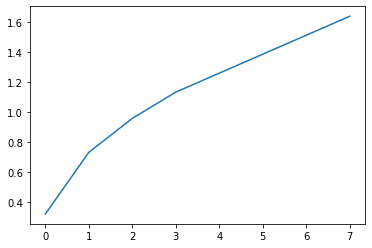

In [9]:
plt.plot(y_df.dte, y_df.bs_price)